In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.decomposition import PCA

DATASET_PATH = "/kaggle/input/fruits/fruits-360_100x100/fruits-360/Training"
IMG_SIZE = (32, 32)
selected_classes = ["Apple Red 1", "Banana 1", "Orange 1", "Pear 1", "Plum 1"]
RANDOM_STATE = 42
PCA_COMPONENTS = 300

In [5]:
X, y = [], []

for label, cls in enumerate(selected_classes):
    folder = os.path.join(DATASET_PATH, cls)
    for fname in os.listdir(folder):
        img_path = os.path.join(folder, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        img = cv2.resize(img, IMG_SIZE)
       
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        gray = cv2.equalizeHist(gray)
        
        gray = gray.astype(np.float32) / 255.0

        X.append(gray.flatten())
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Loaded data:", X.shape)

Loaded data: (2400, 1024)


In [6]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

In [7]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [8]:

pca = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_val_pca   = pca.transform(X_val)
X_test_pca  = pca.transform(X_test)

print("PCA feature dimension:", X_train_pca.shape[1])

PCA feature dimension: 300


In [9]:
 logreg = LogisticRegression( multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=RANDOM_STATE)

In [10]:
epochs = 8
train_acc, val_acc = [], []
train_loss, val_loss = [], []

for epoch in range(epochs):
    logreg.fit(X_train_pca, y_train)

    y_train_prob = logreg.predict_proba(X_train_pca)
    y_val_prob   = logreg.predict_proba(X_val_pca)

    train_loss.append(log_loss(y_train, y_train_prob))
    val_loss.append(log_loss(y_val, y_val_prob))

    train_acc.append(accuracy_score(y_train, logreg.predict(X_train_pca)))
    val_acc.append(accuracy_score(y_val, logreg.predict(X_val_pca)))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

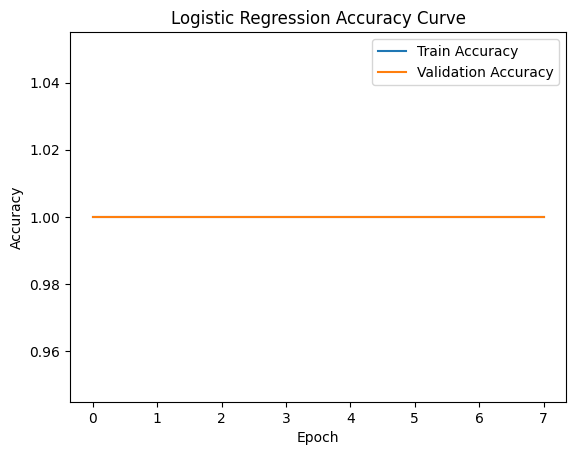

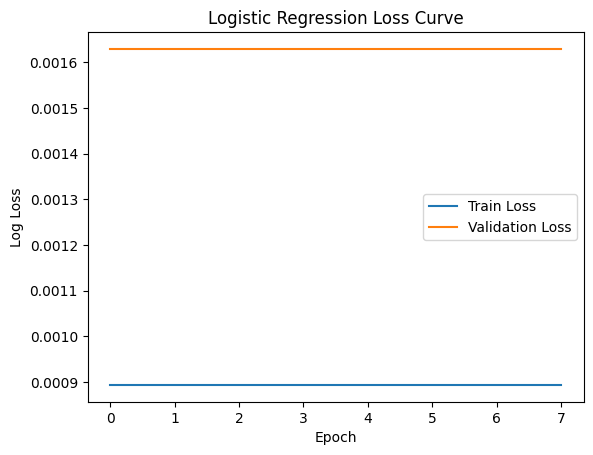

In [11]:

plt.figure()
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy Curve")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Logistic Regression Loss Curve")
plt.legend()
plt.show()

Test Accuracy: 1.0


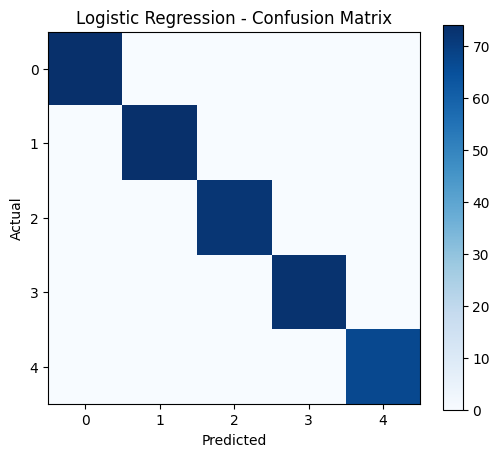

In [12]:
y_pred_lr = logreg.predict(X_test_pca)
y_prob_lr = logreg.predict_proba(X_test_pca)

print("Test Accuracy:", accuracy_score(y_test, y_pred_lr))

cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6,5))
plt.imshow(cm_lr, cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


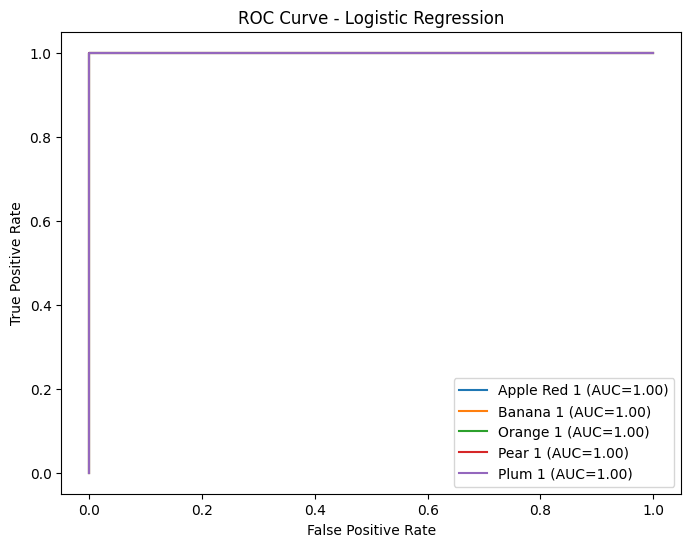

In [13]:
# ROC Curve
y_test_bin = label_binarize(y_test, classes=list(range(len(selected_classes))))
y_score_lr = logreg.predict_proba(X_test_pca)

plt.figure(figsize=(8,6))
for i in range(len(selected_classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_lr[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{selected_classes[i]} (AUC={roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

In [14]:
kmeans = KMeans(n_clusters=len(selected_classes), n_init=50, random_state=42)
kmeans.fit(X_train_pca)
clusters = kmeans.predict(X_test_pca)


In [15]:
cluster_label_probs = {}
for i in range(len(selected_classes)):
    labels = y_test[clusters == i]
    if len(labels) > 0:
        counts = np.bincount(labels, minlength=len(selected_classes))
        cluster_label_probs[i] = counts / counts.sum()

y_pred_prob = np.array([cluster_label_probs[c] for c in clusters])
y_pred = y_pred_prob.argmax(axis=1)

In [16]:

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6444444444444445


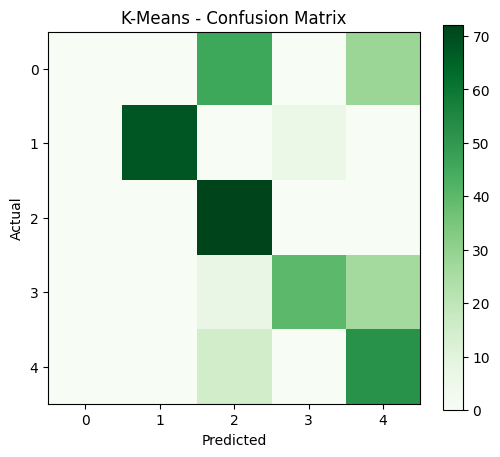

In [17]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Greens")
plt.title("K-Means - Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

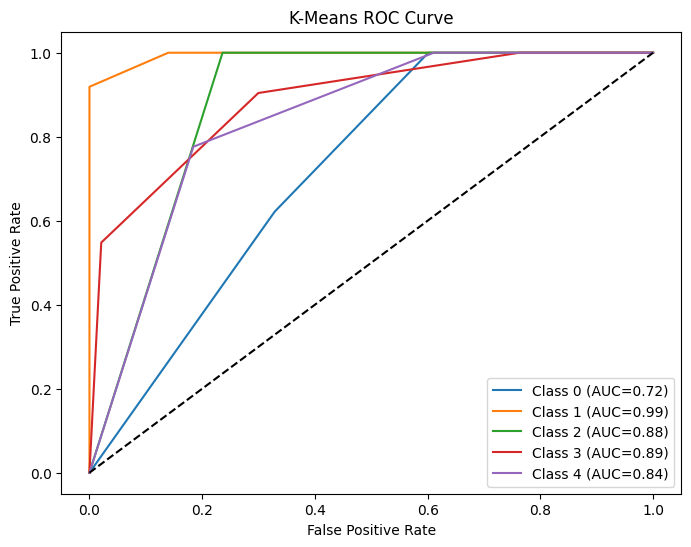

In [18]:

y_test_bin = label_binarize(y_test, classes=range(len(selected_classes)))
plt.figure(figsize=(8,6))
for i in range(len(selected_classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("K-Means ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

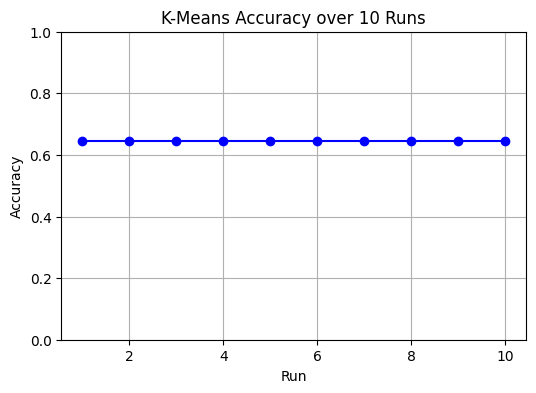

In [19]:
accuracies = []
for i in range(1,11):
    k = KMeans(n_clusters=len(selected_classes), n_init=50, random_state=i)
    k.fit(X_train_pca)
    clusters_i = k.predict(X_test_pca)
    cluster_map_i = {}
    for j in range(len(selected_classes)):
        labels = y_test[clusters_i == j]
        if len(labels) > 0:
            counts = np.bincount(labels, minlength=len(selected_classes))
            cluster_map_i[j] = counts / counts.sum()
    y_pred_prob_i = np.array([cluster_map_i[c] for c in clusters_i])
    y_pred_i = y_pred_prob_i.argmax(axis=1)
    accuracies.append(accuracy_score(y_test, y_pred_i))

plt.figure(figsize=(6,4))
plt.plot(range(1,11), accuracies, marker='o', color='blue')
plt.title("K-Means Accuracy over 10 Runs")
plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

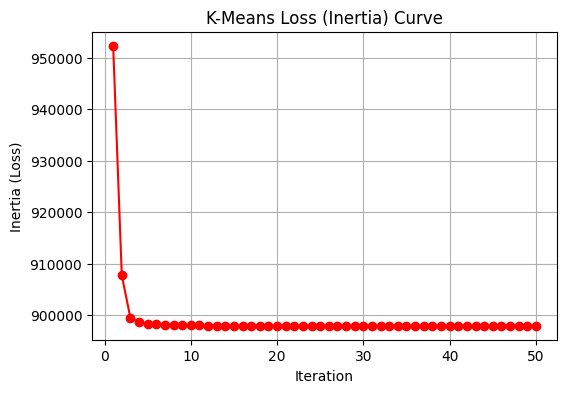

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

losses = []
max_iters = list(range(1, 51)) 

for m in max_iters:
    k = KMeans(n_clusters=len(selected_classes), n_init=1, max_iter=m, random_state=42)
    k.fit(X_train_pca) 
    losses.append(k.inertia_)

plt.figure(figsize=(6,4))
plt.plot(max_iters, losses, marker='o', color='red')
plt.title("K-Means Loss (Inertia) Curve")
plt.xlabel("Iteration")
plt.ylabel("Inertia (Loss)")
plt.grid(True)
plt.show()
